# Microstructure Image Segmentation Tutorial

This notebook gives a quick tutorial to perform image segmentation of microstructure images using deep learning. The notebook is designed for running on Google Colab to use GPUs for computing. Click the button below to run the notebook on Colab.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/holmgroup/img-segmentation/blob/main/img_seg_tutorial.ipynb)


In [2]:
# Setup code
!git clone https://github.com/holmgroup/img-segmentation.git
!pip install segmentation-models-pytorch --quiet
%cd img-segmentation

Cloning into 'img-segmentation'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 70 (delta 27), reused 65 (delta 25), pack-reused 0
Unpacking objects: 100% (70/70), done.
     |████████████████████████████████| 88 kB 3.4 MB/s 
     |████████████████████████████████| 58 kB 4.6 MB/s 
     |████████████████████████████████| 376 kB 27.2 MB/s 
/content/img-segmentation


In [29]:
import os
import numpy as np
import imageio
from matplotlib import pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import segmentation_models_pytorch as smp

In [11]:
torch.cuda.is_available()

True

## Dataset

In [24]:
class DatasetTextSplit(Dataset):
    def __init__(self, root, split_file, size): 
        self.img_dir, self.label_dir = f'{root}/images', f'{root}/labels_npy'
        self.img_names = np.loadtxt(f'{root}/split/{split_file}',
                                    dtype=str, delimiter='\n', ndmin=1)
        self.transform_label = T.Compose([
            T.Resize(size),
            T.ToTensor()
        ]) 
        self.transform_img = T.Compose([
            self.transform_label,
            T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])

    def __getitem__(self, index):
        img_name = self.img_names[index]
        img_path = f'{self.img_dir}/{img_name}'
        label_path = f'{self.label_dir}/{os.path.splitext(img_name)[0]}.npy'
        with open(img_path, 'rb') as f:
            img = Image.open(f)
            img = img.convert('RGB')
            img = self.transform_img(img)
        label = np.load(label_path).astype(np.int8)
        label = Image.fromarray(label)
        label = self.transform_label(label).squeeze()
        return img, label

    def __len__(self): 
        return len(self.img_names) 

In [5]:
root = './data/uhcs'
size = (480, 640)
train_set = DatasetTextSplit(root, split_file='train.txt', size=size)
val_set = DatasetTextSplit(root, split_file='validate.txt', size=size)
test_set = DatasetTextSplit(root, split_file='test.txt', size=size)
print(len(train_set), len(val_set), len(test_set))

16 4 4


## Evaluation Metric: IoU

In [6]:
class ConfMatMeter():
    '''A confusion matrix meter that compute running statistics'''
    def __init__(self, n_classes):
        self.n_classes = n_classes
        self.conf_mat = np.zeros((n_classes, n_classes))

    def add(self, pred, label):
        assert pred.shape == label.shape
        for i in range(self.n_classes):
            for j in range(self.n_classes):
                self.conf_mat[j][i] += np.logical_and(pred==i, label==j).sum()

def iou(conf_mat):
    eps = 1e-8
    n_classes = conf_mat.shape[0]
    IoUs = np.zeros(n_classes)
    for i in range(n_classes):
        union = conf_mat[i,:].sum()+conf_mat[:,i].sum()-conf_mat[i,i]
        IoUs[i] = conf_mat[i,i]/union
    mIoU = IoUs.mean()
    return mIoU

## Train Model

In [12]:
# Basic Parameters
N_CLASSES = 4
DEVICE = 'cpu'

# Hyperparameters
EPOCHS = 20
BATCH_SIZE = 1
LR = 1e-4

In [20]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False)

model = smp.Unet(encoder_name='mobilenet_v2',
                 encoder_weights='imagenet',
                 classes=N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss().to(DEVICE)

train_stats = np.zeros((EPOCHS, 3)) # columns are loss, accuracy, iou
val_stats = np.zeros((EPOCHS, 3))
for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}/{EPOCHS}')
    # start training
    model.train()
    conf_meter = ConfMatMeter(N_CLASSES)
    train_loss, correct, total = 0, 0, 0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(DEVICE), labels.long().to(DEVICE)
        # compute outputs and loss
        outputs = model(inputs)
        preds = outputs.argmax(axis=1)
        loss = criterion(outputs, labels)
        # update statistics
        train_loss += loss.item() * inputs.shape[0]
        correct += (preds == labels).sum()
        total += np.prod(labels.shape)
        conf_meter.add(preds.cpu().numpy(), labels.cpu().numpy())
        # compute gradient and do gradient descent step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss, train_acc = train_loss/len(train_loader), correct/total
    train_iou = iou(conf_meter.conf_mat)
    print('training loss: %.3f, accuracy: %.3f, mIoU: %.3f' % 
          (train_loss, train_acc, train_iou))
    train_stats[epoch, :] = np.array([train_loss, train_acc, train_iou])

    # start validation
    with torch.no_grad():
        model.eval()
        conf_meter = ConfMatMeter(N_CLASSES)
        val_loss, correct, total = 0, 0, 0
        for inputs, labels in tqdm(val_loader):
            inputs, labels = inputs.to(DEVICE), labels.long().to(DEVICE)
            # compute outputs and loss
            outputs = model(inputs)
            preds = outputs.argmax(axis=1)
            loss = criterion(outputs, labels)
            # update statistics
            val_loss += loss.item() * inputs.shape[0]
            correct += (preds == labels).sum()
            total += np.prod(labels.shape)
            conf_meter.add(preds.cpu().numpy(), labels.cpu().numpy())
    val_loss, val_acc = val_loss/len(val_loader), correct/total
    val_iou = iou(conf_meter.conf_mat)
    print('validate loss: %.3f, accuracy: %.3f, mIoU: %.3f' % 
          (val_loss, val_acc, val_iou))
    val_stats[epoch, :] = np.array([val_loss, val_acc, val_iou])

Epoch 0/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss:  1.801, accuracy: 0.171, mIoU: 0.082


  0%|          | 0/4 [00:00<?, ?it/s]

validation loss: 7.456, accuracy: 0.143, mIoU: 0.070
Epoch 1/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss:  1.436, accuracy: 0.336, mIoU: 0.149


  0%|          | 0/4 [00:00<?, ?it/s]

validation loss: 1.397, accuracy: 0.369, mIoU: 0.168
Epoch 2/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss:  1.226, accuracy: 0.566, mIoU: 0.257


  0%|          | 0/4 [00:00<?, ?it/s]

validation loss: 1.205, accuracy: 0.549, mIoU: 0.252
Epoch 3/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss:  1.083, accuracy: 0.697, mIoU: 0.331


  0%|          | 0/4 [00:00<?, ?it/s]

validation loss: 1.093, accuracy: 0.672, mIoU: 0.325
Epoch 4/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss:  0.981, accuracy: 0.757, mIoU: 0.375


  0%|          | 0/4 [00:00<?, ?it/s]

validation loss: 0.967, accuracy: 0.737, mIoU: 0.371
Epoch 5/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss:  0.901, accuracy: 0.786, mIoU: 0.399


  0%|          | 0/4 [00:00<?, ?it/s]

validation loss: 0.905, accuracy: 0.764, mIoU: 0.391
Epoch 6/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss:  0.835, accuracy: 0.807, mIoU: 0.419


  0%|          | 0/4 [00:00<?, ?it/s]

validation loss: 0.829, accuracy: 0.790, mIoU: 0.414
Epoch 7/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss:  0.780, accuracy: 0.820, mIoU: 0.434


  0%|          | 0/4 [00:00<?, ?it/s]

validation loss: 0.823, accuracy: 0.772, mIoU: 0.400
Epoch 8/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss:  0.731, accuracy: 0.831, mIoU: 0.445


  0%|          | 0/4 [00:00<?, ?it/s]

validation loss: 0.754, accuracy: 0.806, mIoU: 0.427
Epoch 9/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss:  0.692, accuracy: 0.838, mIoU: 0.453


  0%|          | 0/4 [00:00<?, ?it/s]

validation loss: 0.738, accuracy: 0.797, mIoU: 0.420
Epoch 10/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss:  0.656, accuracy: 0.845, mIoU: 0.465


  0%|          | 0/4 [00:00<?, ?it/s]

validation loss: 0.683, accuracy: 0.822, mIoU: 0.442
Epoch 11/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss:  0.624, accuracy: 0.850, mIoU: 0.472


  0%|          | 0/4 [00:00<?, ?it/s]

validation loss: 0.667, accuracy: 0.819, mIoU: 0.442
Epoch 12/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss:  0.595, accuracy: 0.855, mIoU: 0.480


  0%|          | 0/4 [00:00<?, ?it/s]

validation loss: 0.615, accuracy: 0.842, mIoU: 0.459
Epoch 13/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss:  0.568, accuracy: 0.858, mIoU: 0.485


  0%|          | 0/4 [00:00<?, ?it/s]

validation loss: 0.637, accuracy: 0.820, mIoU: 0.442
Epoch 14/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss:  0.543, accuracy: 0.862, mIoU: 0.498


  0%|          | 0/4 [00:00<?, ?it/s]

validation loss: 0.584, accuracy: 0.839, mIoU: 0.461
Epoch 15/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss:  0.521, accuracy: 0.866, mIoU: 0.507


  0%|          | 0/4 [00:00<?, ?it/s]

validation loss: 0.592, accuracy: 0.827, mIoU: 0.450
Epoch 16/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss:  0.501, accuracy: 0.869, mIoU: 0.523


  0%|          | 0/4 [00:00<?, ?it/s]

validation loss: 0.540, accuracy: 0.850, mIoU: 0.474
Epoch 17/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss:  0.483, accuracy: 0.872, mIoU: 0.533


  0%|          | 0/4 [00:00<?, ?it/s]

validation loss: 0.523, accuracy: 0.850, mIoU: 0.481
Epoch 18/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss:  0.466, accuracy: 0.875, mIoU: 0.558


  0%|          | 0/4 [00:00<?, ?it/s]

validation loss: 0.518, accuracy: 0.850, mIoU: 0.487
Epoch 19/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss:  0.451, accuracy: 0.877, mIoU: 0.572


  0%|          | 0/4 [00:00<?, ?it/s]

validation loss: 0.507, accuracy: 0.847, mIoU: 0.491


## Evaluation on Test Set

In [26]:
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)
model.eval()
conf_meter = ConfMatMeter(N_CLASSES)
test_loss, correct, total = 0, 0, 0
with torch.no_grad():
    model.eval()
    conf_meter = ConfMatMeter(N_CLASSES)
    test_loss, correct, total = 0, 0, 0
    for inputs, labels in tqdm(test_loader):
        assert inputs.shape[0] == 1 # process single image at a time
        inputs, labels = inputs.to(DEVICE), labels.long().to(DEVICE)
        # compute outputs and loss
        outputs = model(inputs)
        preds = outputs.argmax(axis=1)
        loss = criterion(outputs, labels)
        # update statistics
        test_loss += loss.item() * inputs.shape[0]
        correct += (preds == labels).sum()
        total += np.prod(labels.shape)
        conf_meter.add(preds.cpu().numpy(), labels.cpu().numpy())
test_loss, test_acc = test_loss/len(test_loader), correct/total
test_iou = iou(conf_meter.conf_mat)
print('test loss: %.3f, accuracy: %.3f, mIoU: %.3f' % 
        (test_loss, test_acc, test_iou))

  0%|          | 0/4 [00:00<?, ?it/s]

test loss: 0.472, accuracy: 0.862, mIoU: 0.504


## Visualization

In [52]:
def display(display_list):
    plt.figure(figsize=(10, 10), dpi=150)
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        if i == 0: plt.imshow(display_list[i], cmap='gray')
        else: plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

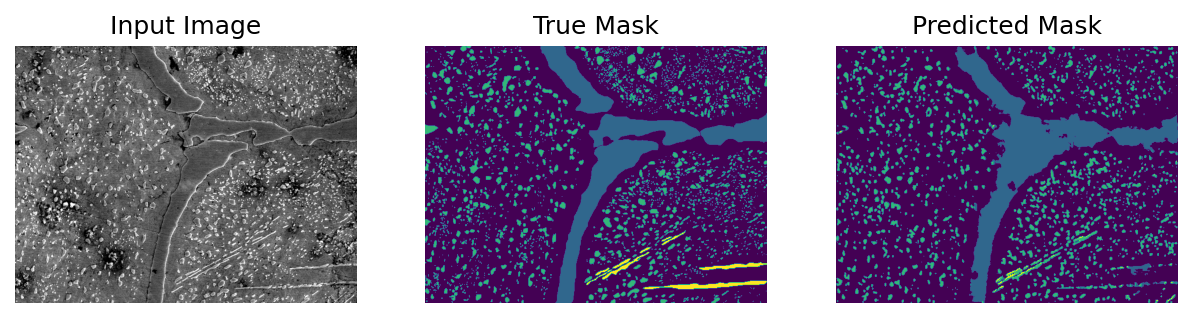

In [53]:
idx = 0
img_name = test_set.img_names[idx]
img = plt.imread(f'{root}/images/{img_name}')
label = np.load(f'{root}/labels_npy/{os.path.splitext(img_name)[0]}.npy')
model.eval()
pred = model(test_set[0][0].unsqueeze(0))[0].argmax(0).detach().cpu().numpy()
display([img, label, pred])